In [42]:
import pandas as pd
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
#import plotly.plotly as py # visualization library
#from plotly.offline import init_notebook_mode, iplot # plotly offline mode
#init_notebook_mode(connected=True) 
#import plotly.graph_objs as go # plotly graphical object
plt.style.use('ggplot') 
import warnings
warnings.filterwarnings('ignore')
from    statsmodels.tsa.seasonal import   seasonal_decompose
from functools import reduce
import numpy as np


#Data Evaluation:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import ccovf,ccf
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
import matplotlib.ticker as ticker

## EDA

### Load data

In [2]:
df = pd.read_csv("fuel_burn_data.csv")

In [3]:
df.head(5)

gas_date  MW_actual_Lewis_Creek1  MW_actual_Lewis_Creek2  \
0  01-01-2014                1299.000                     0.0   
1  02-01-2014                2732.129                     0.0   
2  03-01-2014                3445.157                     0.0   
3  04-01-2014                1362.175                     0.0   
4  05-01-2014                2547.000                     0.0   

   MW_actual_preverified_Lewis_Creek1  MW_actual_preverified_Lewis_Creek2  \
0                              1299.0                                -5.0   
1                              2907.0                                -5.0   
2                              3642.0                                -4.0   
3                              1421.0                                -3.0   
4                              2547.0                                -6.0   

   fuel_burn_actual_Lewis_Creek1  fuel_burn_actual_Lewis_Creek2  \
0                    15796.80902                            0.0   
1                    28850.49202                            0.0   
2                    35496.94442                            0.0   
3                    16723.12597                            0.0   
4                    27005.17132                            0.0   

   fuel_burn_actual_total  fuel_burn_actual_total_preverified  hdd_actual  \
0             15796.80902                         15796.80902         NaN   
1             28850.49202                         30609.25407         NaN   
2             35496.94442                         37476.68947         NaN   
3             16723.12597                         17318.48984         NaN   
4             27005.17132                         27005.17132         NaN   

   cdd_actual  temp_actual  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN

In [4]:
df.gas_date = pd.to_datetime(df.gas_date, format = '%d-%m-%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3110 entries, 0 to 3109
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   gas_date                            3110 non-null   datetime64[ns]
 1   MW_actual_Lewis_Creek1              3110 non-null   float64       
 2   MW_actual_Lewis_Creek2              3110 non-null   float64       
 3   MW_actual_preverified_Lewis_Creek1  3110 non-null   float64       
 4   MW_actual_preverified_Lewis_Creek2  3110 non-null   float64       
 5   fuel_burn_actual_Lewis_Creek1       3110 non-null   float64       
 6   fuel_burn_actual_Lewis_Creek2       3110 non-null   float64       
 7   fuel_burn_actual_total              3110 non-null   float64       
 8   fuel_burn_actual_total_preverified  3110 non-null   float64       
 9   hdd_actual                          1325 non-null   float64       
 10  cdd_actual              

### Check for Missing Dates

In [5]:
print("Min date: {},   Max date: {}".format(df.gas_date.min(), df.gas_date.max()))

Min date: 2014-01-01 00:00:00,   Max date: 2022-07-07 00:00:00


In [6]:
pd.date_range(start = '2014-01-01', end = '2022-06-07' ).difference(df.gas_date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

**There are no missing dates in the data**

In [7]:
df

gas_date  MW_actual_Lewis_Creek1  MW_actual_Lewis_Creek2  \
0    2014-01-01                1299.000                     0.0   
1    2014-01-02                2732.129                     0.0   
2    2014-01-03                3445.157                     0.0   
3    2014-01-04                1362.175                     0.0   
4    2014-01-05                2547.000                     0.0   
...         ...                     ...                     ...   
3105 2022-07-03                3799.000                  3786.0   
3106 2022-07-04                4195.000                  4204.0   
3107 2022-07-05                4279.000                  4303.0   
3108 2022-07-06                3435.000                  3576.0   
3109 2022-07-07                   0.000                     0.0   

      MW_actual_preverified_Lewis_Creek1  MW_actual_preverified_Lewis_Creek2  \
0                                 1299.0                                -5.0   
1                                 2907.0                                -5.0   
2                                 3642.0                                -4.0   
3                                 1421.0                                -3.0   
4                                 2547.0                                -6.0   
...                                  ...                                 ...   
3105                              3799.0                              3786.0   
3106                              4195.0                              4204.0   
3107                              4279.0                              4303.0   
3108                              4273.0                              4416.0   
3109                              3460.0                              3656.0   

      fuel_burn_actual_Lewis_Creek1  fuel_burn_actual_Lewis_Creek2  \
0                       15796.80902                        0.00000   
1                       28850.49202                        0.00000   
2                       35496.94442                        0.00000   
3                       16723.12597                        0.00000   
4                       27005.17132                        0.00000   
...                             ...                            ...   
3105                    39194.47527                    37930.25579   
3106                    43191.30645                    42053.94687   
3107                    43546.17945                    42635.42738   
3108                    33858.19388                    34555.61780   
3109                        0.00000                        0.00000   

      fuel_burn_actual_total  fuel_burn_actual_total_preverified  hdd_actual  \
0                15796.80902                         15796.80902         NaN   
1                28850.49202                         30609.25407         NaN   
2                35496.94442                         37476.68947         NaN   
3                16723.12597                         17318.48984         NaN   
4                27005.17132                         27005.17132         NaN   
...                      ...                                 ...         ...   
3105             77124.73106                         77124.73106         0.0   
3106             85245.25332                         85245.25332         0.0   
3107             86181.60683                         86181.60683         0.0   
3108             68413.81167                         87238.54813         0.0   
3109                 0.00000                         69517.41136         0.0   

      cdd_actual  temp_actual  
0            NaN          NaN  
1            NaN          NaN  
2            NaN          NaN  
3            NaN          NaN  
4            NaN          NaN  
...          ...          ...  
3105        20.6         85.6  
3106        20.8         85.8  
3107        21.2         86.2  
3108        20.0         83.6  
3109        13.7         91.0  

[3110 rows x 12 columns]

### Check for missing values

In [8]:
hdd_miss_year = df.hdd_actual.isnull().groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='missing_count_in_hdd')
cdd_miss_year = df.cdd_actual.isnull().groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='missing_count_in_cdd')
temp_miss_year = df.temp_actual.isnull().groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='missing_count_in_temp')

data_frames = [hdd_miss_year, cdd_miss_year, temp_miss_year]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gas_date'],
                                            how='inner'), data_frames)
df_merged

gas_date  missing_count_in_hdd  missing_count_in_cdd  missing_count_in_temp
0      2014                   365                   365                    365
1      2015                   365                   365                    365
2      2016                   366                   366                    366
3      2017                   365                   365                    365
4      2018                   324                   324                    324
5      2019                     0                     0                      0
6      2020                     0                     0                      0
7      2021                     0                     0                      0
8      2022                     0                     0                      0

### Check for Zero Values in fuel_burn_actual_total_preverified

In [9]:
total_fuel_zero_year = (df.fuel_burn_actual_total_preverified==0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='zero_in_total_fuel')
LC2_fuel_zero_year = (df.fuel_burn_actual_Lewis_Creek2==0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='zero_in_LC2_fuel')
LC1_fuel_zero_year = (df.fuel_burn_actual_Lewis_Creek1==0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='zero_in_LC1_fuel')

data_frames = [df_merged, LC1_fuel_zero_year, LC2_fuel_zero_year,total_fuel_zero_year]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gas_date'],
                                            how='inner'), data_frames)
df_merged

gas_date  missing_count_in_hdd  missing_count_in_cdd  \
0      2014                   365                   365   
1      2015                   365                   365   
2      2016                   366                   366   
3      2017                   365                   365   
4      2018                   324                   324   
5      2019                     0                     0   
6      2020                     0                     0   
7      2021                     0                     0   
8      2022                     0                     0   

   missing_count_in_temp  zero_in_LC1_fuel  zero_in_LC2_fuel  \
0                    365               159                55   
1                    365                76                76   
2                    366               121                39   
3                    365               141                59   
4                    324                81                59   
5                      0                92                61   
6                      0                64                83   
7                      0                66               130   
8                      0                75                 7   

   zero_in_total_fuel  
0                   0  
1                   2  
2                   4  
3                   0  
4                   0  
5                   0  
6                  23  
7                   8  
8                   0

### Check for negatives Values in fuel_burn_actual_total_preverified


In [10]:
total_fuel_zero_year = (df.fuel_burn_actual_total_preverified<0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='Negative_in_total_fuel')
LC2_fuel_zero_year = (df.fuel_burn_actual_Lewis_Creek2<0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='Negative_in_LC2_fuel')
LC1_fuel_zero_year = (df.fuel_burn_actual_Lewis_Creek1<0).groupby([df['gas_date'].dt.year]).sum().astype(int).reset_index(name='Negative_in_LC1_fuel')

data_frames = [df_merged, LC1_fuel_zero_year, LC2_fuel_zero_year,total_fuel_zero_year]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gas_date'],
                                            how='inner'), data_frames)
df_merged

gas_date  missing_count_in_hdd  missing_count_in_cdd  \
0      2014                   365                   365   
1      2015                   365                   365   
2      2016                   366                   366   
3      2017                   365                   365   
4      2018                   324                   324   
5      2019                     0                     0   
6      2020                     0                     0   
7      2021                     0                     0   
8      2022                     0                     0   

   missing_count_in_temp  zero_in_LC1_fuel  zero_in_LC2_fuel  \
0                    365               159                55   
1                    365                76                76   
2                    366               121                39   
3                    365               141                59   
4                    324                81                59   
5                      0                92                61   
6                      0                64                83   
7                      0                66               130   
8                      0                75                 7   

   zero_in_total_fuel  Negative_in_LC1_fuel  Negative_in_LC2_fuel  \
0                   0                     0                     2   
1                   2                     0                     1   
2                   4                     0                     1   
3                   0                     0                     0   
4                   0                     0                     2   
5                   0                     0                     0   
6                  23                     0                     4   
7                   8                     0                     2   
8                   0                     0                     1   

   Negative_in_total_fuel  
0                       0  
1                       1  
2                       1  
3                       0  
4                       0  
5                       0  
6                       1  
7                       0  
8                       0

### Replacing Negative with zero and zero  with forward fill value

In [11]:
df['fuel_burn_actual_total_preverified'] =np.where((df['fuel_burn_actual_total_preverified'] < 0), 0 , df['fuel_burn_actual_total_preverified'])
df['fuel_burn_actual_Lewis_Creek2'] =np.where((df['fuel_burn_actual_Lewis_Creek2'] < 0), 0 , df['fuel_burn_actual_Lewis_Creek2'])
df['fuel_burn_actual_Lewis_Creek1'] =np.where((df['fuel_burn_actual_Lewis_Creek1'] < 0), 0 , df['fuel_burn_actual_Lewis_Creek1'])
df['fuel_burn_actual_total_preverified'] = df['fuel_burn_actual_total_preverified'].replace(0,pd.np.nan).ffill()

Creating a copy of dataframe and setting gas date as index

In [12]:
df1 = df.copy()
df1 = df[['gas_date','fuel_burn_actual_total_preverified', 'fuel_burn_actual_Lewis_Creek2', 'fuel_burn_actual_Lewis_Creek1']]
df1.set_index('gas_date', inplace =True)

#### FUEL BURN TOTAL PLOT

<AxesSubplot:xlabel='gas_date'>

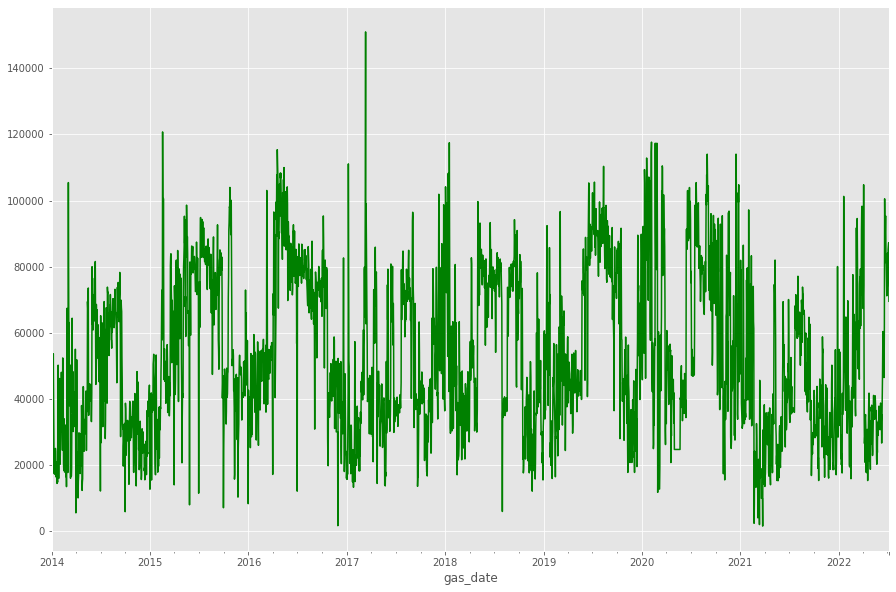

In [13]:
df1['fuel_burn_actual_total_preverified'].plot(color = 'green',figsize=(15, 10))

#### FUEL BURN PLANTS PLOT

<AxesSubplot:xlabel='gas_date'>

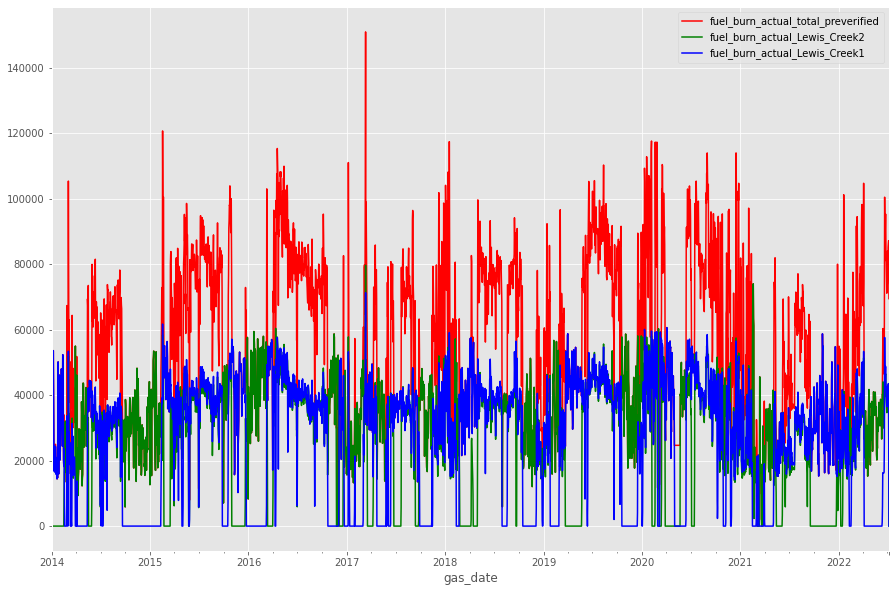

In [14]:
df1.plot(color = ['red', 'green', 'blue'],figsize=(15, 10))

### Correlation plot

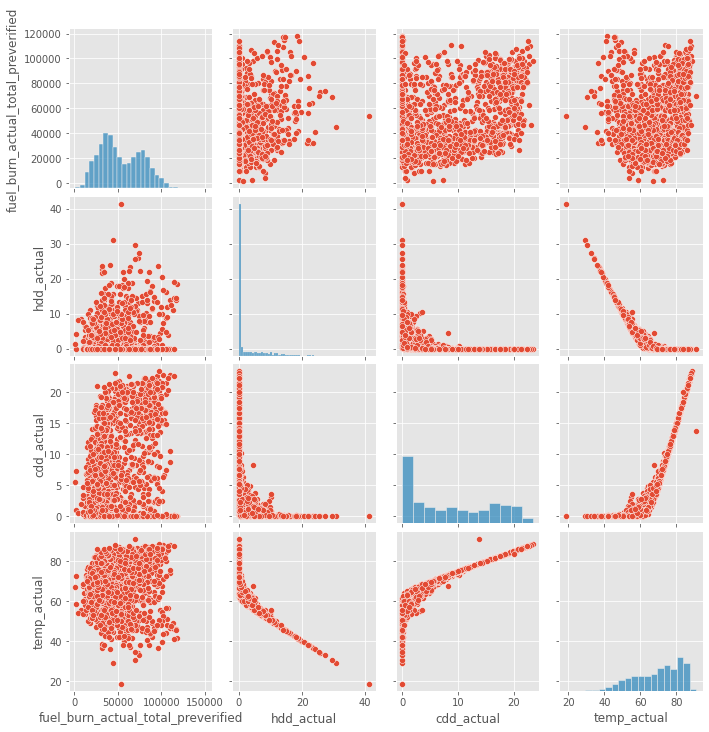

In [15]:
sns.pairplot(df[['fuel_burn_actual_total_preverified', 'hdd_actual', 'cdd_actual', 'temp_actual']])
plt.show()

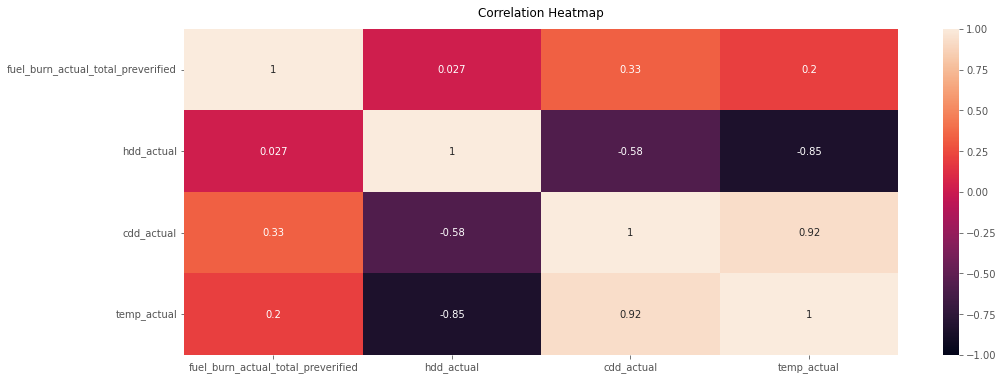

In [16]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df[['fuel_burn_actual_total_preverified', 'hdd_actual', 'cdd_actual', 'temp_actual']].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Statistical description of the data

In [17]:
round(df.fuel_burn_actual_total_preverified.describe(),3)

count      3110.000
mean      53629.025
std       24021.278
min        1496.749
25%       34585.764
50%       49071.789
75%       74038.296
max      151033.343
Name: fuel_burn_actual_total_preverified, dtype: float64

 **Fuel burnt ranges from zero units to 151033.343 units, hinting huge variation in sales across days.**

### Yearly Boxplot:

In [18]:
df2 = df1[['fuel_burn_actual_total_preverified']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


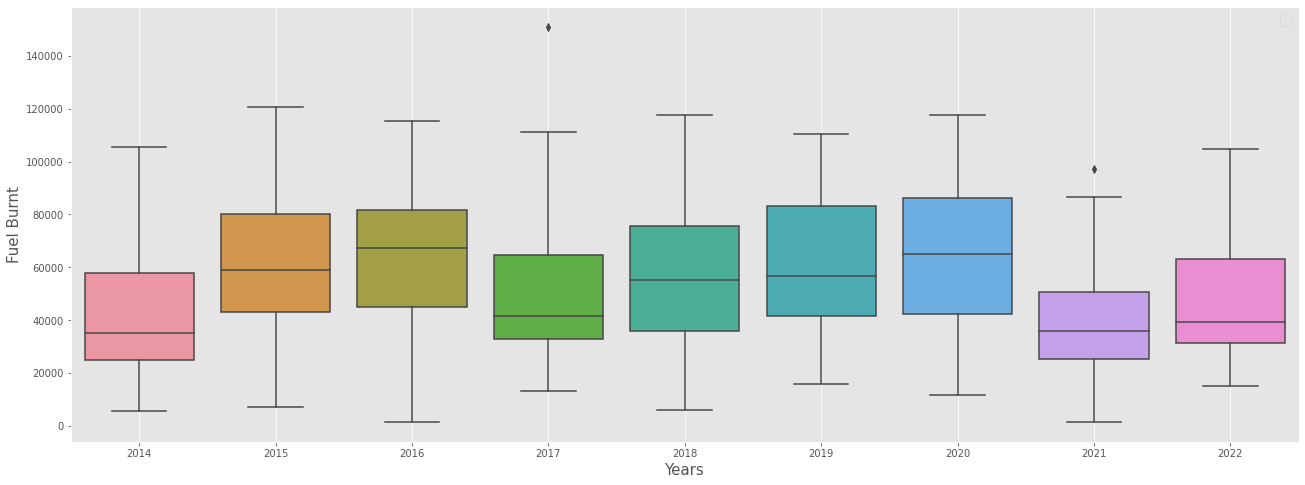

In [19]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df2.index.year,y = df2.values[:,0],ax=ax)
plt.grid();
plt.xlabel('Years',fontsize=15)
plt.ylabel('Fuel Burnt',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

### Monthly Boxplot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


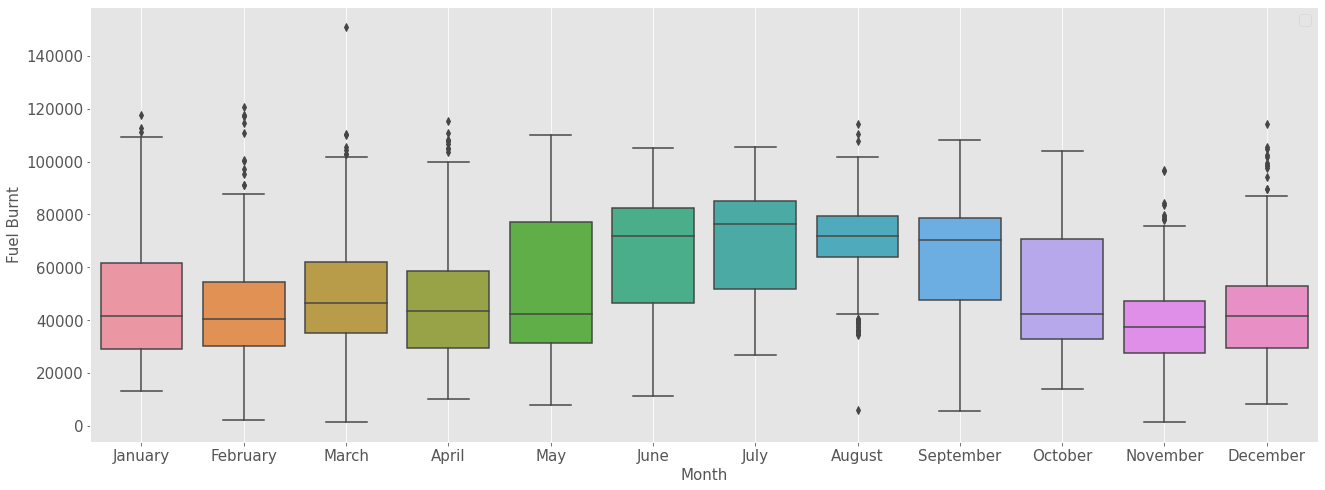

In [20]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df2.index.month_name(),y = df2.values[:,0],ax=ax)

plt.grid();
plt.xlabel('Month',fontsize=15)
plt.ylabel('Fuel Burnt',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

### Monthly sales across years

In [21]:
monthly_fuels_across_years = pd.pivot_table(df2, values = 'fuel_burn_actual_total_preverified', 
                                            columns = df2.index.month_name(), 
                                            index = df2.index.year)
monthly_fuels_across_years

gas_date         April        August      December      February  \
gas_date                                                           
2014      25575.982999  63612.617379  26861.582676  32944.325416   
2015      62945.239554  75841.775425  46154.280584  52736.255130   
2016      87537.429369  73969.294034  36966.342421  47375.257102   
2017      51742.142792  68668.964862  63553.354734  30657.599490   
2018      47793.711423  50205.112770  39451.824719  41857.716043   
2019      45521.790073  90053.521380  50176.132516  37064.137860   
2020      44356.749025  81695.953274  59347.167104  68559.292223   
2021      24768.072598  62399.176996  33403.944308  45152.752681   
2022      36258.847825           NaN           NaN  40584.801614   

gas_date       January          July          June         March  \
gas_date                                                           
2014      26065.545014  53908.830981  59990.598006  41615.869011   
2015      34272.656386  83275.269092  77169.052449  52174.359370   
2016      42054.805461  80787.834482  78904.673776  53015.913675   
2017      30821.854672  49813.221756  51914.001469  59039.717164   
2018      65588.849047  74344.019377  75196.860011  36249.243445   
2019      50463.659545  90363.576892  79790.297129  52147.934449   
2020      83633.512443  74733.519069  69657.813089  60655.602863   
2021      51442.009675  46407.851523  42889.635096  18989.634614   
2022      44577.902782  80521.584299  56277.731661  68432.943307   

gas_date           May      November       October     September  
gas_date                                                          
2014      44001.170311  27469.076597  30877.259438  50095.575560  
2015      70864.690076  39986.133719  62825.286573  68627.644003  
2016      94339.021201  40873.457310  61733.993042  69680.937469  
2017      33898.388333  51100.620808  34998.271718  48189.415844  
2018      78307.239161  30801.415384  48987.974287  75411.648626  
2019      52610.436422  35600.010368  63594.145021  74834.800392  
2020      29383.483052  53765.551487  63796.673009  83038.542475  
2021      34493.365738  32724.463418  34145.095764  40163.345985  
2022      32389.684563           NaN           NaN           NaN

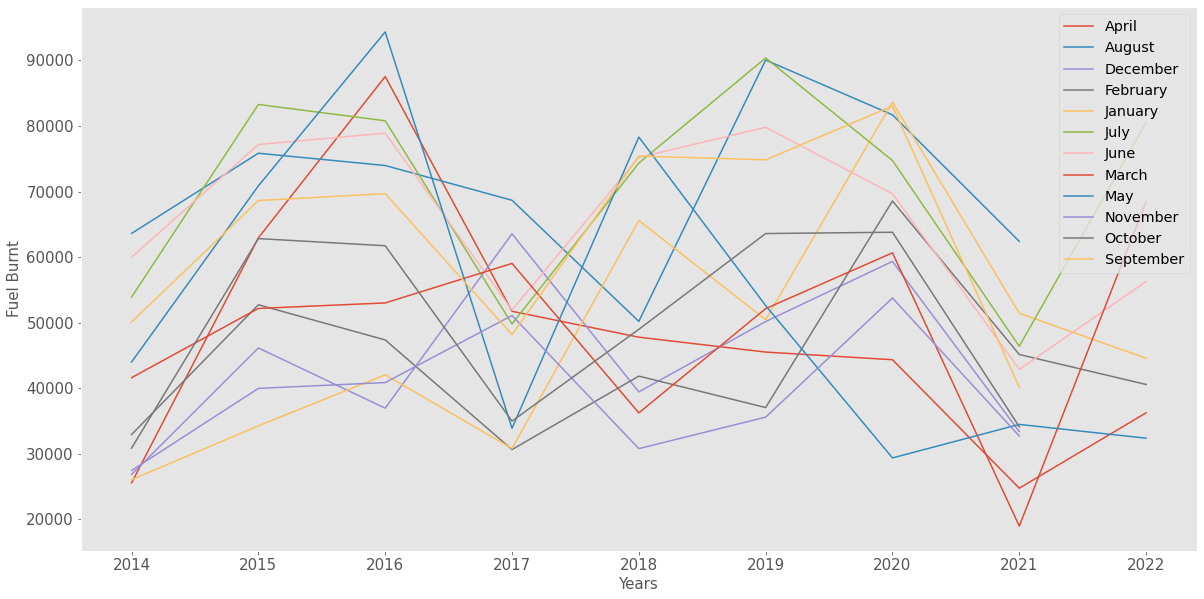

In [22]:
monthly_fuels_across_years.plot(figsize=(20,10))
plt.grid()
plt.legend(loc='best');
plt.xlabel('Years',fontsize=15)
plt.ylabel('Fuel Burnt',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

### Quarterly Fuel burnt across years

In [23]:
quarterly_fuel = pd.pivot_table(df2, values = "fuel_burn_actual_total_preverified", columns = df2.index.quarter, index = df2.index.year)
quarterly_fuel.columns = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4']
quarterly_fuel

Quarter1      Quarter2      Quarter3      Quarter4
gas_date                                                        
2014      33561.832738  43198.172635  55935.132239  28412.786994
2015      46183.029245  70332.243433  75994.105436  49760.332537
2016      47484.337903  87008.491776  74868.468566  46586.023029
2017      40490.239029  45720.157870  55637.285440  49870.859177
2018      48099.965739  67222.434693  66558.397341  39844.306856
2019      46875.058599  59233.913683  85195.370198  49944.336029
2020      71002.000538  47596.976242  79787.716488  59026.365088
2021      38307.311645  34055.226030  49759.981127  33432.110269
2022      51552.340822  41540.413253  80521.584299           NaN

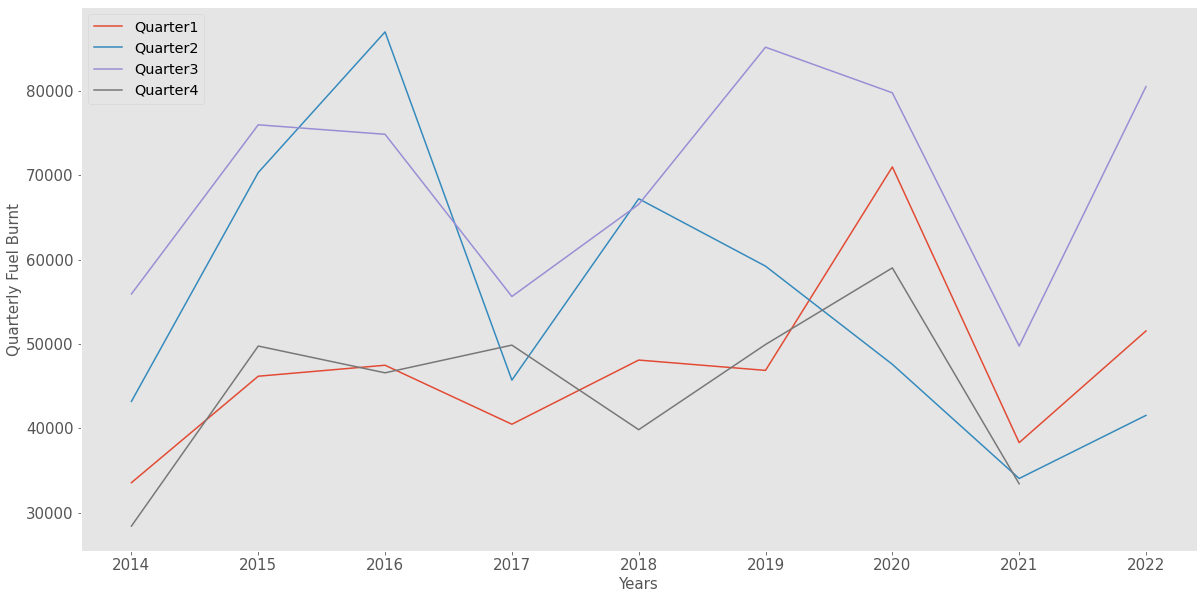

In [24]:
quarterly_fuel.plot(figsize=(20,10))
plt.grid()
plt.legend(loc='best');
plt.xlabel('Years',fontsize=15)
plt.ylabel('Quarterly Fuel Burnt',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

### Plotting the Empirical Cumulative Distribution:

It’s quite good to know the position of the average values across the historic timestamp; particularly during the subsequent model evaluation phases of time-series modeling. As the expanding technique eventually helps us to compare the Root Mean squared Error against the cumulative mean of the sales to understand the scale of variance

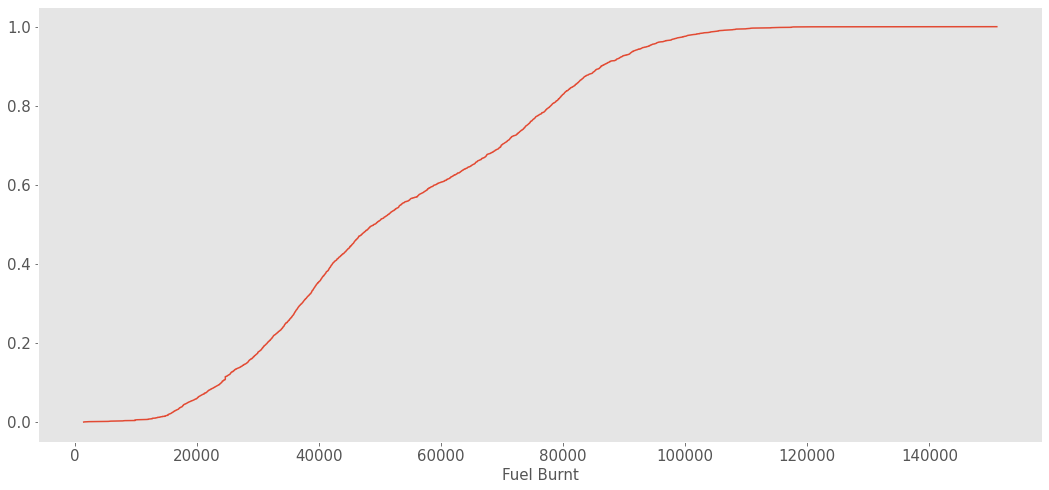

In [25]:
from statsmodels.distributions.empirical_distribution import ECDF
plt.figure(figsize = (18, 8))
cdf = ECDF(df2['fuel_burn_actual_total_preverified'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.grid()
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Fuel Burnt', fontsize = 15);

Around 60% of all the days had 60000 units or lesser sales

### Plot the average sales per month and the month on month percentage change of sales:

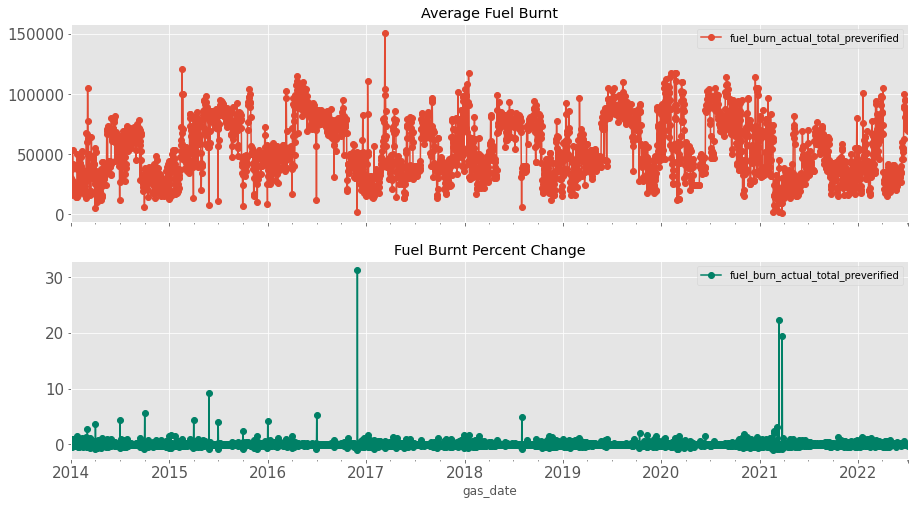

In [26]:
# group by date and get average Customers, and precent change
average    = df2.groupby(df2.index)["fuel_burn_actual_total_preverified"].mean()
pct_change = df2.groupby(df2.index)["fuel_burn_actual_total_preverified"].sum().pct_change()

fig, (axis1,axis2) = plt.subplots(2,1,sharex=True,figsize=(15,8))

# plot average Customers over time(year-month)
ax1 = average.plot(legend=True,ax=axis1,marker='o',title="Average Fuel Burnt",grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for Customers over time(year-month)
ax2 = pct_change.plot( legend=True,ax=axis2,marker='o', colormap="summer", title="Fuel Burnt Percent Change", grid=True )

### Plot sales for every year

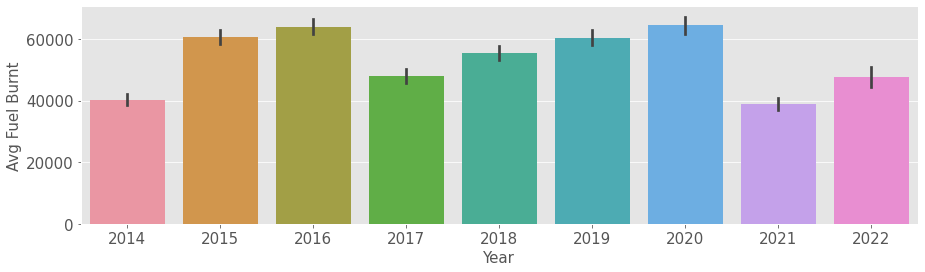

In [27]:
## Plot sales for every year
fig, (axis1) = plt.subplots(1,figsize=(15,4))

sns.barplot(x=df2.index.year, y=df2.values[:,0], data=df2, ax=axis1);
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel('Year', fontsize = 15);
plt.ylabel('Avg Fuel Burnt', fontsize = 15);

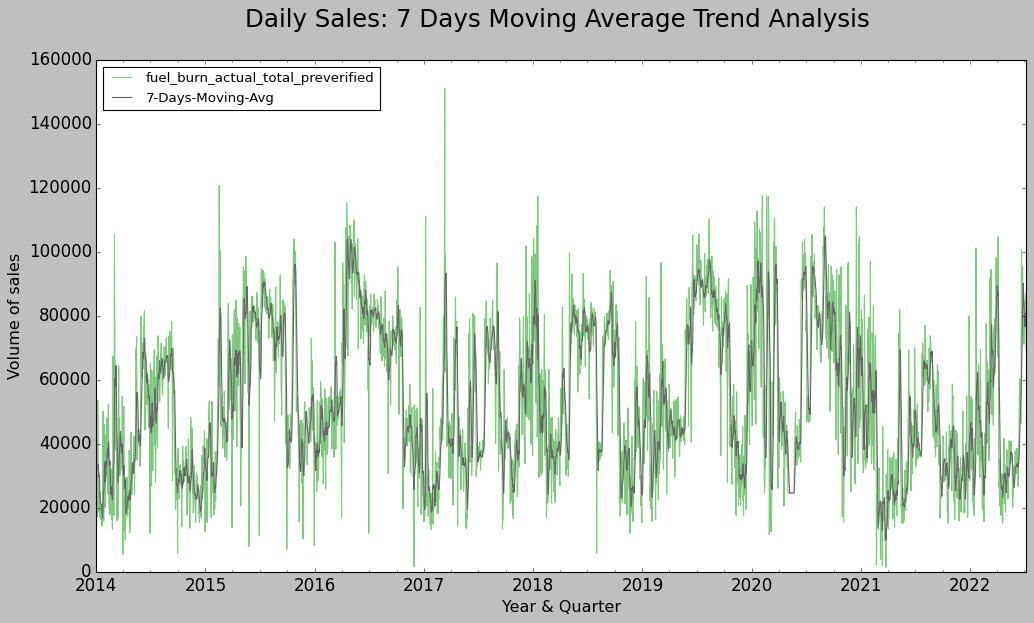

In [35]:
df2["7-Days-Moving-Avg"] = df2["fuel_burn_actual_total_preverified"].rolling(window=7).mean()
#Plot the Graph:
ax =  df2[['fuel_burn_actual_total_preverified', '7-Days-Moving-Avg']].plot.line(
title = '7 days Moving Average Trend Analysis'
, legend =True, table = False, grid = False,  
subplots = False,  figsize =(15,8), colormap = 'Accent', 
fontsize = 15,linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Volume of sales',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Sales: 7 Days Moving Average Trend Analysis \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)


### Standard Deviation of Timeseries Analysis

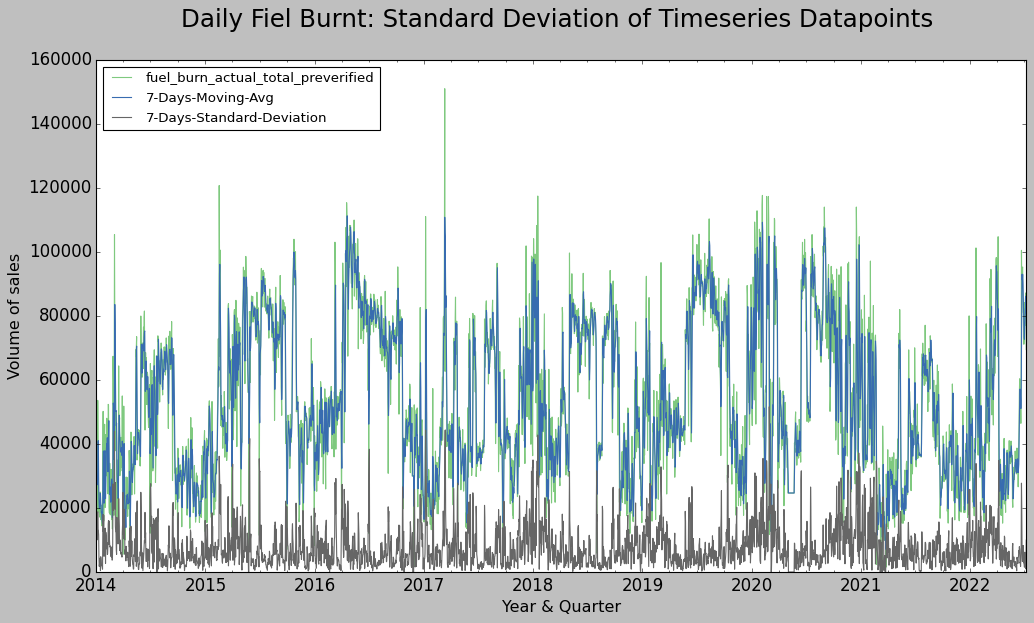

In [38]:
df2['7-Days-Moving-Avg'] = df2['fuel_burn_actual_total_preverified'].rolling(window=3).mean()
df2['7-Days-Standard-Deviation'] = df2['fuel_burn_actual_total_preverified'].rolling(window=3).std()
#Plot the Graph:
ax =  df2[['fuel_burn_actual_total_preverified', '7-Days-Moving-Avg', '7-Days-Standard-Deviation']].plot.line(title = 'Standard Deviation of Timeseries Datapoints', legend =True, table = False, grid = False,  subplots = False,  figsize =(15,8), colormap = 'Accent', fontsize = 15,linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Volume of sales',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Fiel Burnt: Standard Deviation of Timeseries Datapoints \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

### Expanding Timeseries Dataset

The expanding process in time-series analysis assists us to identify the “stability” or “volatility” of the sale movements. So, when we apply the expanding technique over a time-series dataset, we will be able to essentially see the cumulative average value of Sales across each historic time-series observations in the dataset.

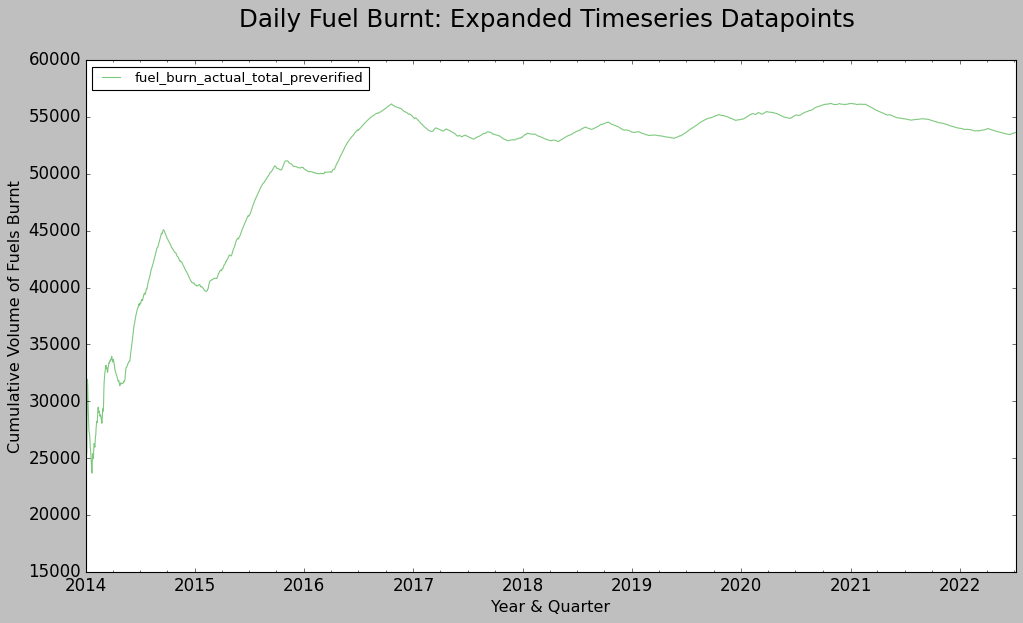

In [40]:
#Plot the Graph:
ax =  df2['fuel_burn_actual_total_preverified'].expanding().mean().plot.line(
title = 'Expandind Timeseries Datapoints', legend =True, 
table = False, grid = False,  subplots = False,  figsize =(15,8), colormap = 'Accent', fontsize = 15,linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Cumulative Volume of Fuels Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Fuel Burnt: Expanded Timeseries Datapoints \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

### Evaluate Error, Trend, and Seasonality:

A useful abstraction for selecting forecasting models is to decompose a time series into systematic and unsystematic components. Systematic: Components of the time series that have consistency or recurrence and can be described and modeled. Non-Systematic: Components of the time series that cannot be directly modeled.

#### Hodrick-Prescott Filter:

Hodrick-Prescott filter decomposes a time-series dataset into the trend and cyclical components.

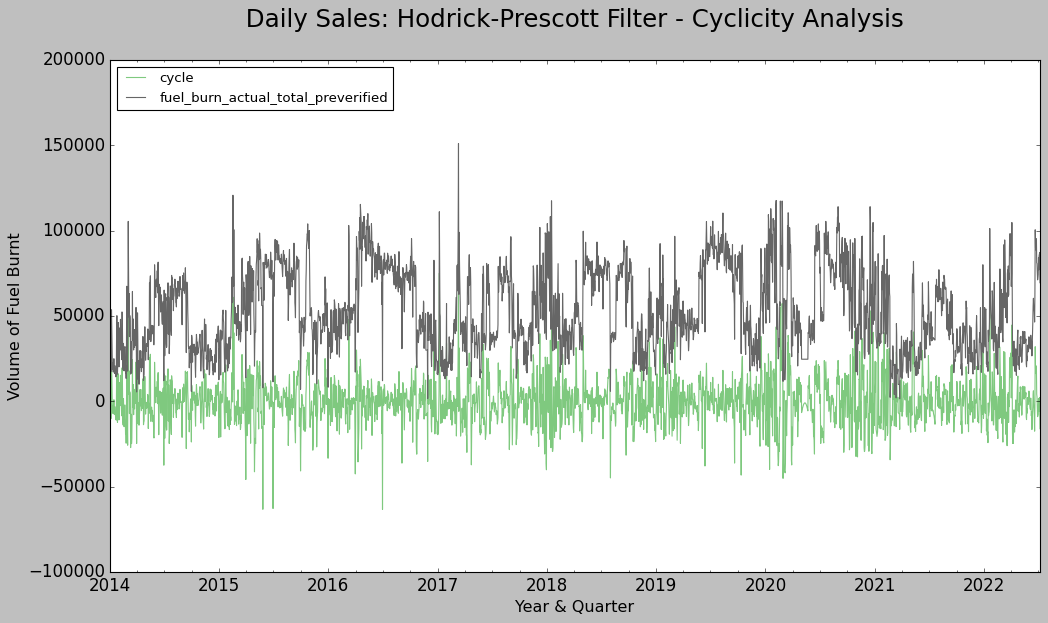

In [48]:

#cyclicity:
sales_cycle, sales_trend = hpfilter(
df2["fuel_burn_actual_total_preverified"], lamb = 1600)
df2["cycle"] = sales_cycle
#Plot the Graph:
ax =  df2[["cycle", "fuel_burn_actual_total_preverified"]].plot.line(
title = 'Hodrick-Prescott Filter - Cyclicity'
, legend =True, table = False, grid = False
,  subplots = False,  figsize =(15,8), colormap = 'Accent'
, fontsize = 15,linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title(' Daily Sales: Hodrick-Prescott Filter - Cyclicity Analysis \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

A cyclic pattern exists when data exhibit rises and falls that are not of a fixed period. Also, if cyclicity values near zero, then it indicates that the data is “random”. The more the result differs from zero, the more likely some cyclicity exists. As we could see here, there is cyclicity in the chosen dataset

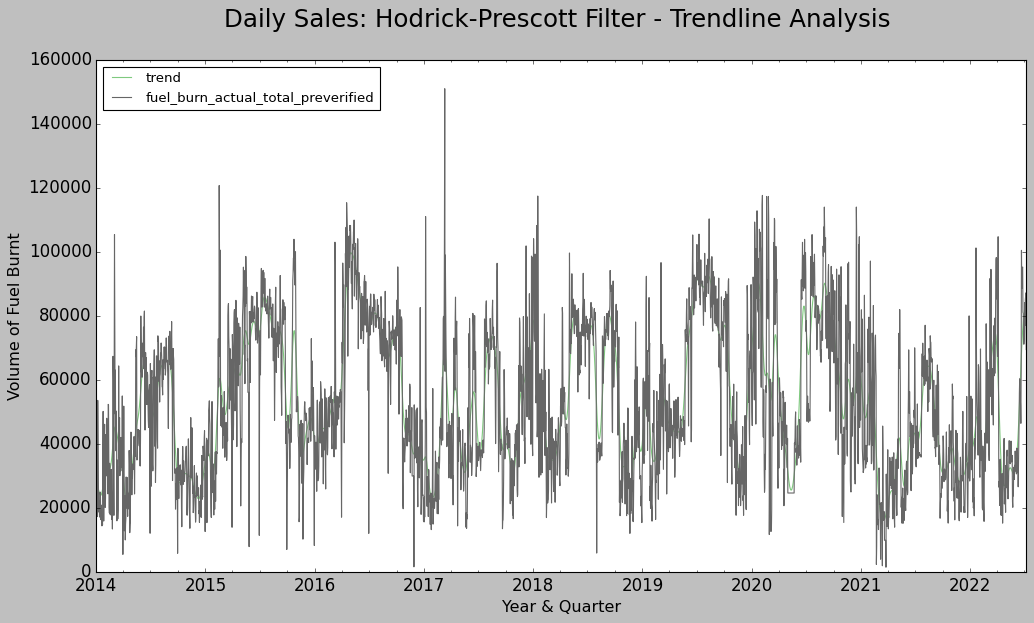

In [47]:
#Trendline
df2 ["trend"] = sales_trend
#Plot the Graph:
ax =  df2[["trend", "fuel_burn_actual_total_preverified"]].plot.line(
title = 'Hodrick-Prescott Filter - Trendline', 
legend =True, table = False, grid = False,  subplots = False,  figsize =(15,8), colormap = 'Accent', fontsize = 15,
linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title('Daily Sales: Hodrick-Prescott Filter - Trendline Analysis \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

The trendline of the observed values of the datapoints indicates an overall growth pattern at a non-linear rate over the course of time.

### Decomposing the Time Series and plotting the different components.

A given time-series consists of three systematic components including level, trend, seasonality, and one non-systematic component called noise/error/residual. The decomposition of the time series in this section attempts to isolate these individual systematic & non-systematic components of a time-series; throwing a graph containing four aforesaid plots.

A multiplicative model is more appropriate where  sales seem to be increasing at a non-linear rate. On the other hand, we apply an ‘additive’ model on a time-series when the seasonality and trend components seem to be constant over time

#### Assuming Additive Decomposition:

An additive model suggests that the components are added together. it is linear where changes over time are consistently made by the same amount.

Actual = Trend + Seasonality + Residual

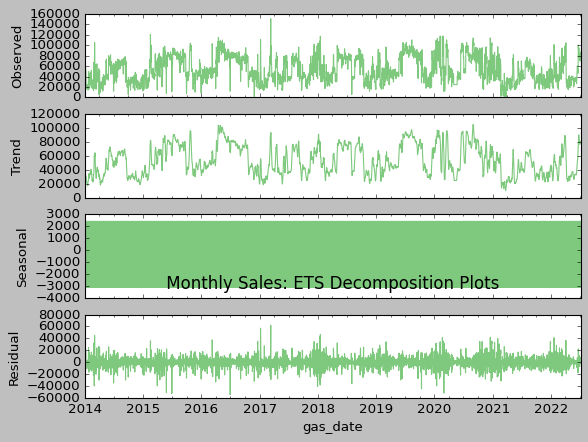

In [51]:
result = seasonal_decompose(df2["fuel_burn_actual_total_preverified"]
, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, colormap = 'Accent')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, colormap = 'Accent')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, colormap = 'Accent')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, colormap = 'Accent')
axes[3].set_ylabel('Residual')
plt.title(""" Monthly Sales: ETS Decomposition Plots \n""",horizontalalignment="center", fontstyle = "normal", fontsize = "15", fontfamily = "sans-serif")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

### Assuming Multiplicative Decomposition:

A multiplicative model suggests that the components are multiplied together. It is non-linear such as quadratic or exponential.

Actual = Trend x Seasonality x Residual

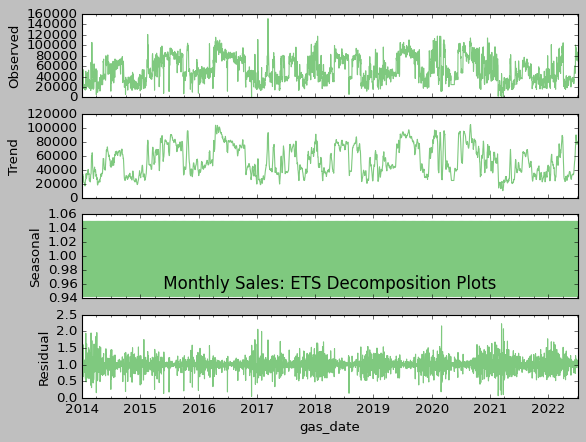

In [50]:
result = seasonal_decompose(df2["fuel_burn_actual_total_preverified"]
, model = "multiplicative")
fig, axes = plt.subplots(4, 1, sharex=True)
result.observed.plot(ax=axes[0], legend=False, colormap = 'Accent')
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, colormap = 'Accent')
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, colormap = 'Accent')
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, colormap = 'Accent')
axes[3].set_ylabel('Residual')
plt.title(""" Monthly Sales: ETS Decomposition Plots \n""",horizontalalignment="center", fontstyle = "normal", fontsize = "15", fontfamily = "sans-serif")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

In the additive model, We observe that the trend and seasonality are clearly separated and the scale of noise is small. In the additive model, there are outliers present in the residual. So the series is multiplicative.

The standard Deviation of the chosen time-series dataset seems to be constant with time; hinting stationarity. We will get to the stationarity in subsequent steps.

#### Auto Correlation (ACF) Plots for seasonality check:

Autocorrelation is a type of serial dependence where a time-series is linearly related to a lagged version of itself. Lagging means nothing but “backshifting” — as simple as that. Therefore ‘lagged version of itself’ fundamentally means the datapoints get backshifted by a certain number of periods/lags.

So, if we run an autocorrelation function over the time-series dataset, we basically plot the same set of data points post backshifting it to a certain number of periods/ lags.

On average, plotting the magnitude of the autocorrelations over the first few (20–40) lags can say a lot about a time series. By doing so, we will be able to easily uncover and verify the seasonality component in time-series data.

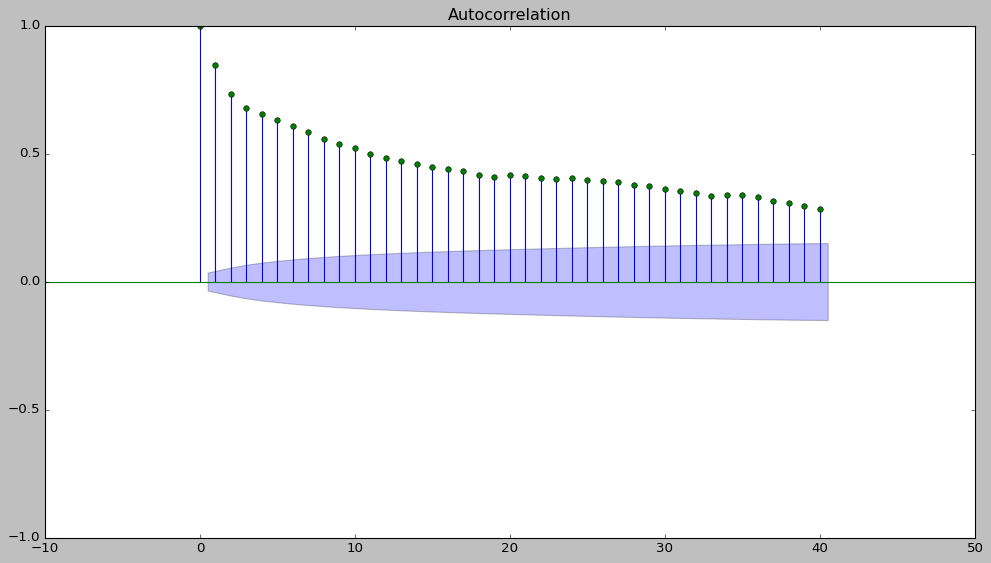

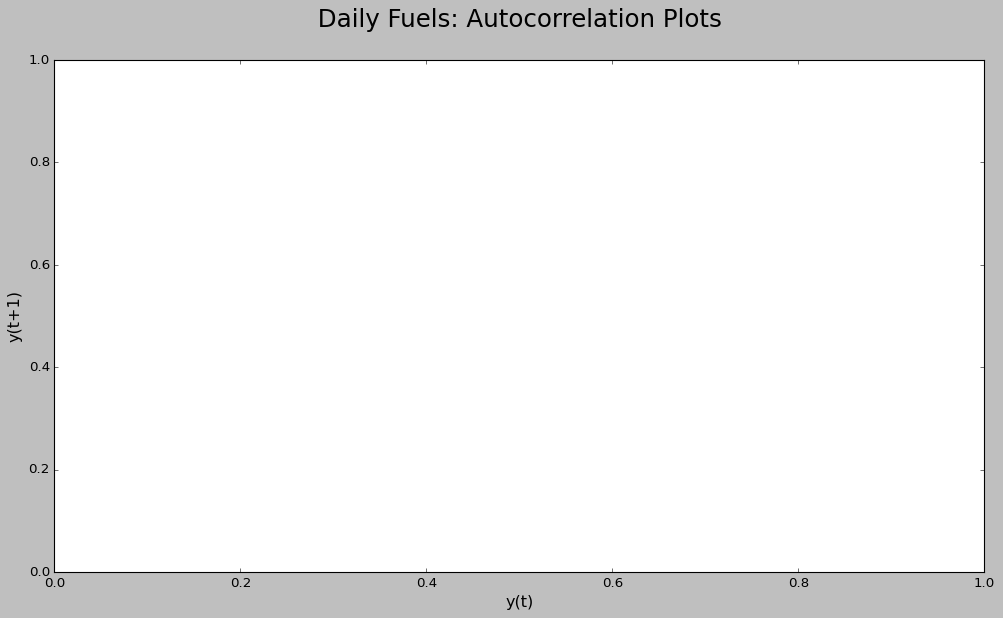

In [80]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
acf(df2["fuel_burn_actual_total_preverified"])
lags = 40
plot_acf(df2["fuel_burn_actual_total_preverified"], 
lags = lags, color = 'g', ax = ax);
plt.figure(figsize=(15,8)) 
plt.title(' Daily Fuels: Autocorrelation Plots \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.ylabel('y(t+1)',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('y(t)',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

By plotting the lagged ACF, we can confirm that seasonality does exist in this time-series dataset in the first place. As the lagged ACF plot is showcasing a predictable pattern of seasonality in the data. We are able to clearly see a seasonal pattern of ups and downs consisting of a fixed number of timestamps before the second-largest positive peak erupts. Every data point seems to be strongly correlating with another data point in the future; indicating a strong seasonality in the dataset.

#### Stationarity Check

Time series data is said to be stationary if it does not exhibit trends or seasonality. That is; it’s mean, variance and covariance remain the same for any segment of the series and are not functions of time.

Let’s reconfirm the stationarity of the time-series dataset using the automated Dickey-Fuller & KPSS tests and further by plotting the lagged autocorrelation and partial correlation functions of the dataset as shown here below:

Augmented Dickey-Fuller Test for stationarity:

The Augmented Dickey-Fuller test for stationarity usually involves a unit root hypothesis test, where the null hypothesis H0 states that the series is nonstationary. The alternate hypothesis H1 supports stationarity.

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
input_dataframe_test = adfuller(df2["fuel_burn_actual_total_preverified"], autolag = 'AIC')
input_dataframe_test
#For loop to assign dimensions to the metrices:
    
print('Augmented Dickey-Fuller Test on Fuel Data')
input_dataframe_out = pd.Series(input_dataframe_test[0:4], 
                                index = ['ADF test statistic', 'p-value', '#lags used', '#observations'])
for key, val in input_dataframe_test[4].items():
    input_dataframe_out[f'critical value ({key})'] = val
    
print(input_dataframe_out)

Augmented Dickey-Fuller Test on Fuel Data
ADF test statistic       -5.802
p-value                   0.000
#lags used               19.000
#observations          3090.000
critical value (1%)      -3.432
critical value (5%)      -2.862
critical value (10%)     -2.567
dtype: float64


Here we have a p-value at 0.00 ( p<0.05 ), which provides strong evidence against the null hypothesis, and so reject the null hypothesis. Therefore we decide that our dataset is stationary.

Here’s is a custom function to automatically check stationarity using the ADF test:

In [72]:
#Custom function to check stationarity using ADF test:
    
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        print(out.to_string())          
        # .to_string() removes the line "dtype: float64"

        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")
        else:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
        
# Calling custom Augmented Dickey-Fuller function to check stationarity:
adf_test(df2["fuel_burn_actual_total_preverified"], title = "Automated ADF Test for Stationarity")

Augmented Dickey-Fuller Test: Automated ADF Test for Stationarity
ADF test statistic      -5.802
p-value                  0.000
# lags used             19.000
# observations        3090.000
critical value (1%)     -3.432
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
ADF test statistic      -5.802
p-value                  0.000
# lags used             19.000
# observations        3090.000
critical value (1%)     -3.432
critical value (5%)     -2.862
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
ADF test statistic       -5.802
p-value                   0.000
# lags used              19.000
# observations         3090.000
critical value (1%)      -3.432
critical value (5%)      -2.862
critical value (10%)     -2.567
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test for stationarity:

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test results are directly opposite to that of the ADF test when it comes to interpreting the null and alternate hypothesis. That is; the KPSS test for stationarity usually involves a unit root hypothesis test, where the null hypothesis H0 states that the series is stationary with a large p-value ( p>0.05 ) whilst the alternate hypothesis H1 supports non-stationarity indicating weak evidence against the null hypothesis.

In [73]:
def kpss_test(timeseries):    
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=
    ['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)
# calling kpss test to check stationarity
kpss_test(df2["fuel_burn_actual_total_preverified"])

Results of KPSS Test:
Test Statistic          0.264
p-value                 0.100
Lags Used              30.000
Critical Value (10%)    0.347
dtype: float64
Test Statistic          0.264
p-value                 0.100
Lags Used              30.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
dtype: float64
Test Statistic           0.264
p-value                  0.100
Lags Used               30.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
dtype: float64
Test Statistic           0.264
p-value                  0.100
Lags Used               30.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64


Here we have a high p-value at 0.1 ( p>0.05 ), which provides strong evidence against the null hypothesis, indicating that our time-series is stationary.



#### Revalidate stationarity using lag & autocorrelation plots:

Lag plots:

When we plot y(t) against y(t+1) on a dataset, we will be able to find a strong autocorrelation; that is as y(t) values increase, nearby lagged values also increases.

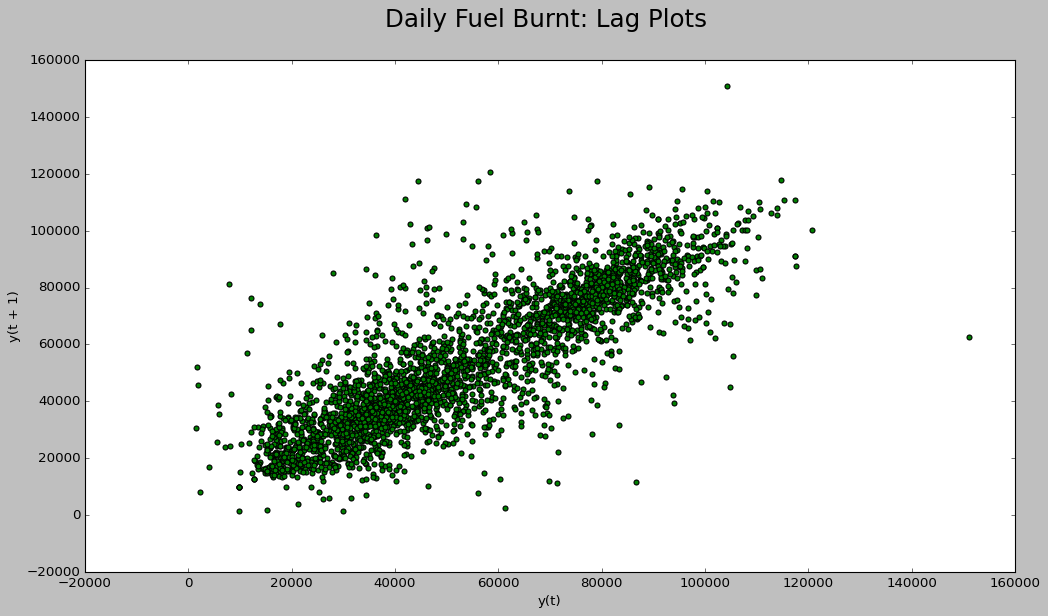

In [75]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
lag_plot(df2["fuel_burn_actual_total_preverified"], c= 'g', ax = ax);
plt.title('Daily Fuel Burnt: Lag Plots \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

Partial Auto Correlation (PACF) plots:

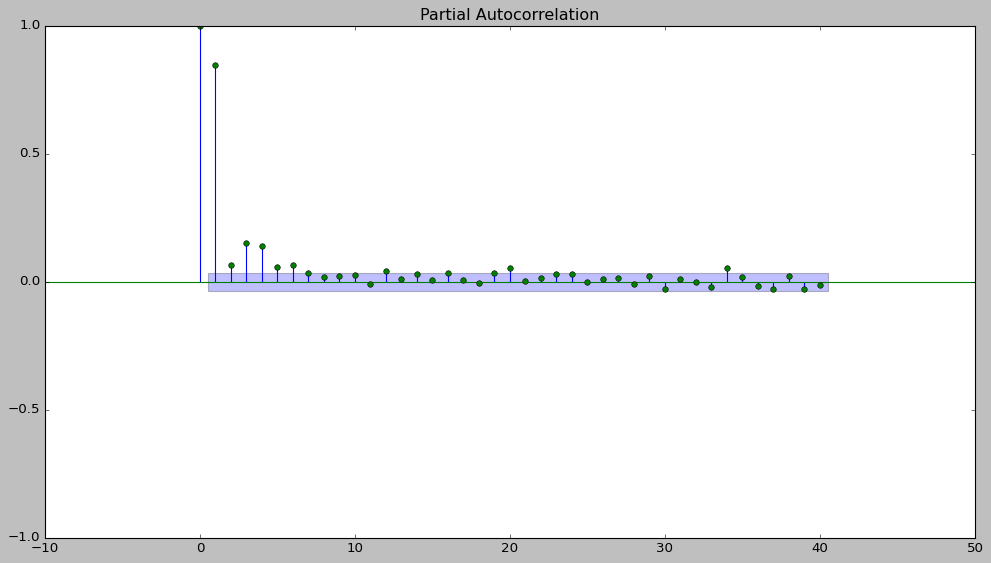

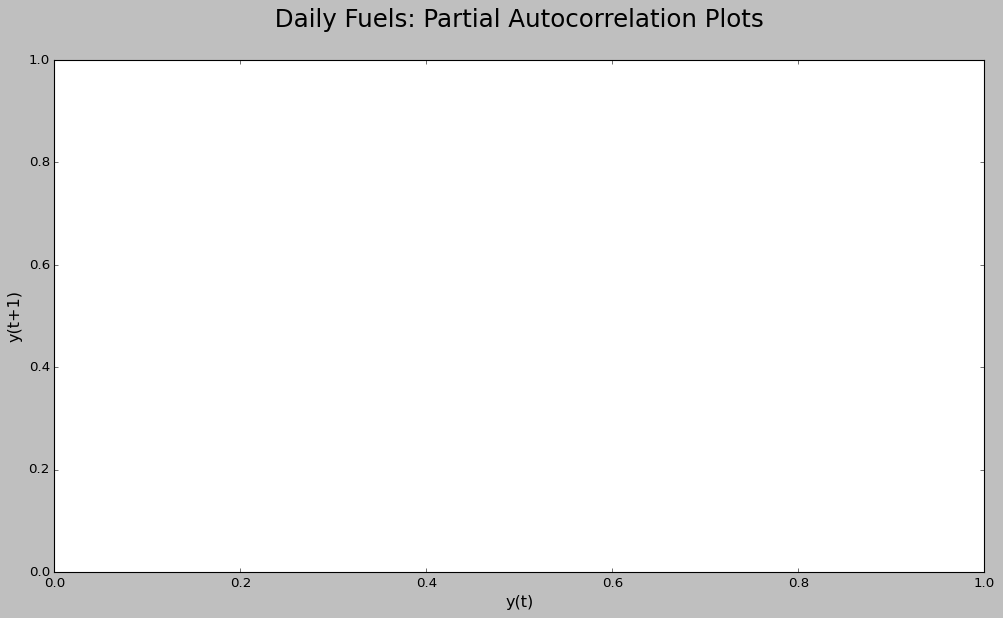

In [79]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
pacf(df2["fuel_burn_actual_total_preverified"])
lags = 40
plot_pacf(df2["fuel_burn_actual_total_preverified"], 
lags = lags, color = 'g', ax = ax);
plt.figure(figsize=(15,8)) 
plt.title(' Daily Fuels: Partial Autocorrelation Plots \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.ylabel('y(t+1)',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('y(t)',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

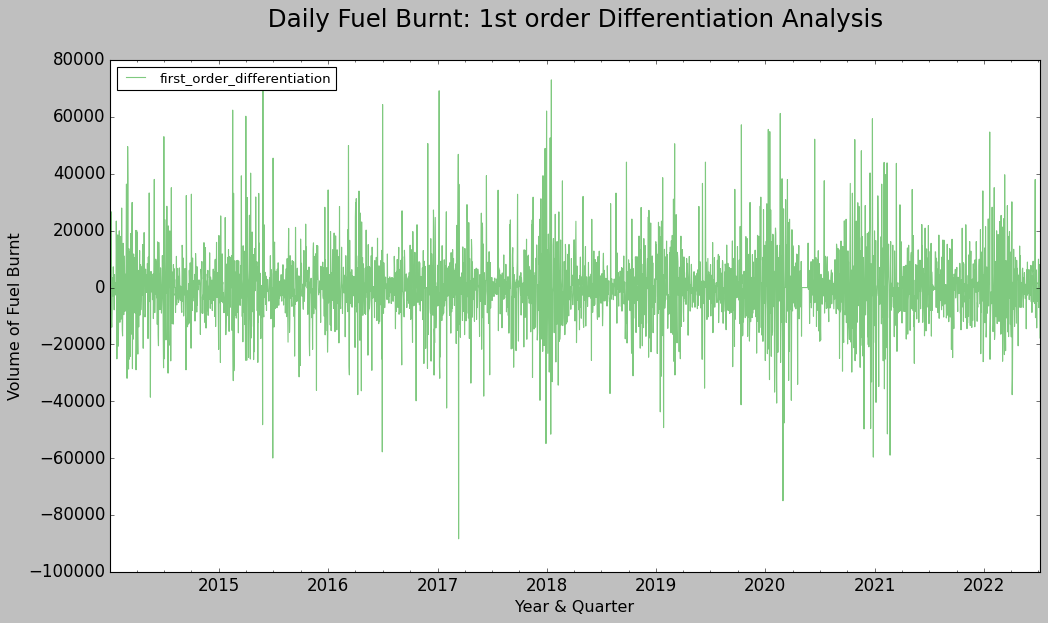

In [82]:

df2["first_order_differentiation"] = diff(df2["fuel_burn_actual_total_preverified"], k_diff = 1)
#Plot the Graph:
ax =  df2["first_order_differentiation"].plot.line(title = 'Daily Fuel Burnt Timeseries Data : 1st order Differentiation'
, legend =True, table = False, grid = False , subplots = False,  figsize =(15,8), colormap = 'Accent', fontsize = 15,linestyle='-', stacked=False)
#Configure x and y labels:
plt.ylabel('Volume of Fuel Burnt',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Year & Quarter',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#Set up title, legends and theme:
plt.title(' Daily Fuel Burnt: 1st order Differentiation Analysis \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper left', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.style.use(['classic'])
ax.autoscale(enable=True, axis='x', tight=False)

In [ ]:
df.to_csv("cleaned_fuel_data.csv", index=False)